# Better Population Model

In this notebook, we repeat the policy analysis with a population model that is more representative of the population of agents in our case study. Note that here we assume that the various parameters that make up the population are independent of one another. This is unlikely to be the case, as skill is likely to be correlated with a number of other metrics, etc. The hope is to demonstrate that with a population model that is better than the toy population we used before, the general results of the analysis hold. This builds confidence that they would continue to hold with the perfect population model that we can never achieve.

In [1]:
%pylab inline 
import pysd
import numpy as np
import multiprocessing
from functools import partial
import seaborn
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/Users/houghton/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
model = pysd.read_vensim('Three streamsc.mdl')

In [3]:
#simplifies one run of the model
def runner(case, params):
    """
    case: dict
        contains the parameters that are varied by the monte carlo simulation
    
    params: dict
        contains the model parameters that are set as the 'control'
    """
    model = pysd.load('Three streamsc.py')
    params.update(case)

    res = model.run(params,
                    return_columns=['still_employed', 'tier_1_sales',
                                    'tier_2_sales', 'tier_3_sales', 
                                    'tier_1_clients', 'tier_2_clients',
                                    'tier_3_clients'],
                    return_timestamps=[3, 36])
    
    month36_no_failout = res['still_employed'].loc[36] > 0
    month3_no_failout = res['still_employed'].loc[3] > 0
    
    month3_sales = (res['tier_1_sales'].loc[3]+
                    res['tier_2_sales'].loc[3]+
                    res['tier_3_sales'].loc[3])
            
    
    month36_clients = res['tier_1_clients'].loc[36] + res['tier_2_clients'].loc[36] + res['tier_3_clients'].loc[36]
    month36_orphans = 0 if month36_no_failout else month36_clients #note that to really capture orphans, we'd need to get the number of clients at the time when each agent fails...
    month36_tier3_clients = res['tier_3_clients'].loc[36]        
            
    pass_review = res['still_employed'].loc[3] > 0
            
    return month36_no_failout, month3_sales, month3_no_failout, month36_orphans, month36_tier3_clients

runner(case={'initial_buffer':6, 'effort_required_to_make_a_sale':2},
       params={'startup_subsidy':0,'startup_subsidy_length':0})

(False, 4.8780735612553476, True, 26.421155173475842, 0.011239134226636584)

In [4]:
def plotter(results, title, fire_level=0):
    plt.figure(figsize=(6,3))
    fired = 0.0
    retained = 0.0
    failed = 0.0
    total = 0.0
    total_tier_3 = 0.0
    total_orphans = 0.0
    for case, result in zip(cases, results):
        total += 1
        total_orphans += result[3]
        if result[1] < fire_level and result[2]:
            color = 'bo'
            fired += 1
        elif not result[0]:
            color = 'ro'
            failed += 1
        else:
            color = 'go'
            retained += 1
            total_tier_3 += result[4] #want to have and maintain tier3 clients
        #color = 'go' if result[0] else 'ro'
        plt.plot(case['initial_buffer'], case['effort_required_to_make_a_sale'], color, alpha=.3)
    
    plt.ylim(0,6)
    plt.xlim(0,14)
    plt.xlabel('Initial Buffer [Months]') 
    plt.ylabel('Effort Required to Make a Sale [Hours]')
    plt.title(title);
    plt.text(14.1,5,"Agent Retention: %.03f"%(retained/total), fontsize=12)
    plt.text(14.1,4,"Fail-out Rate:%.03f"%(failed/total), fontsize=12)
    plt.text(14.1,3,"Orphaned Clients per Agent Start: %.02f"%(total_orphans/total), fontsize=12)
    plt.text(14.1,2,"Tier 3 Clients per Agent Start: %.02f"%(total_tier_3/total), fontsize=12)
    plt.text(14.1,1,"Tier 3 Clients per Continuing Agent: %.02f"%(total_tier_3/retained), fontsize=12)
    
    if fire_level > 0:
        plt.text(14.1,0,"Review Fail Rate: %.03f"%(fired/total), fontsize=12)


### Population Model

These values are based upon responses to questions about model parameters in our interviews. Interviews gave mean and estimates of confidence intervals, to which these distributions were hand-fit. This hand-fitting introduces some error, but the estimation process is noisy to begin with, and more detailed statistical fitting would not be appropriate.

client_lifetime                        10.337028
down_referral_fraction                  0.199131
effort_required_to_make_a_sale          4.050886
fraction_of_effort_for_sales            0.284819
frequency_of_meetings                   0.086019
initial_buffer                          6.209693
lead_shelf_life                         3.018816
minimum_time_to_make_a_sale             1.046938
months_of_expenses_per_tier_1_sale      0.024784
months_of_expenses_per_tier_2_sale      0.247841
months_of_expenses_per_tier_3_sale      2.478414
referrals_per_meeting                   2.640182
success_rate                            0.194071
time_per_client_meeting                 1.027841
total_effort_available                203.404255
up_referral_fraction                    0.167649
dtype: float64


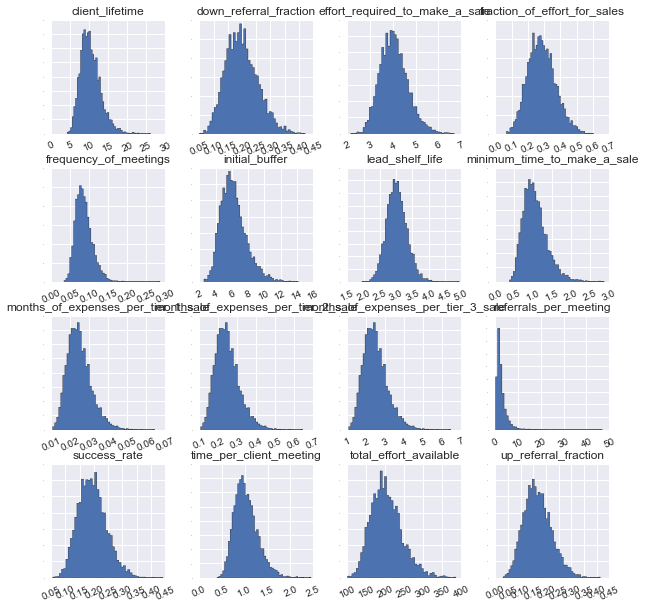

In [69]:
num_agents = 5000

tier2_expenses = np.random.lognormal(mean=np.log(12./50), sigma=.25, size=num_agents)
agents = pd.DataFrame({
    'effort_required_to_make_a_sale': np.random.lognormal(mean=np.log(4), sigma=.15, size=num_agents),
    'fraction_of_effort_for_sales': np.random.beta(a=8,b=20, size=num_agents),
    'initial_buffer': np.random.lognormal(mean=np.log(6), sigma=.25, size=num_agents),
    'minimum_time_to_make_a_sale': np.random.lognormal(mean=np.log(1), sigma=.3, size=num_agents),
    'referrals_per_meeting': np.random.lognormal(mean=np.log(2), sigma=.75, size=num_agents),
    'up_referral_fraction': np.random.beta(a=8,b=40, size=num_agents),
    'down_referral_fraction': np.random.beta(a=10,b=40, size=num_agents),
    'success_rate': np.random.beta(a=12,b=50, size=num_agents),
    'frequency_of_meetings': np.random.lognormal(mean=np.log(1.0/12), sigma=.25, size=num_agents),
    'lead_shelf_life': np.random.lognormal(mean=np.log(3), sigma=.1, size=num_agents),
    'client_lifetime': np.random.lognormal(mean=np.log(10), sigma=.25, size=num_agents),
    'time_per_client_meeting': np.random.lognormal(mean=np.log(1), sigma=.25, size=num_agents),
    'months_of_expenses_per_tier_1_sale': tier2_expenses/10,
    'months_of_expenses_per_tier_2_sale': tier2_expenses,
    'months_of_expenses_per_tier_3_sale': tier2_expenses*10, 
    'total_effort_available': np.random.lognormal(mean=np.log(200), sigma=.2, size=num_agents)
    })
cases = [d[1] for d in agents.iterrows()]

agents.hist(bins=50, histtype='stepfilled', figsize=(10,10), ylabelsize=0, xrot=25);
print agents.mean()

## Baseline

In [70]:
params={'startup_subsidy':0,'startup_subsidy_length':0}
results0 = [runner(case, params) for case in cases[:]]

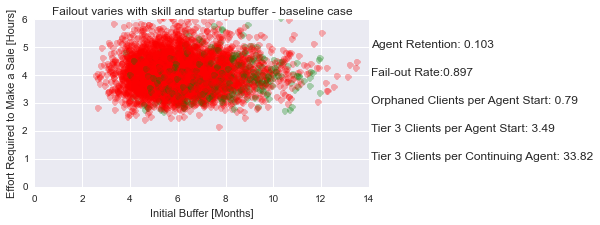

In [71]:
plotter(results0, 'Failout varies with skill and startup buffer - baseline case')

## Improving Productivity
When the productivity improves (ie, more time with client, overhead declines, etc) for a given skill, this is the same as scaling the phenomenon according to the effort required to make a sale, as they are multiplied by one another.

In [72]:
params={'startup_subsidy':0,'startup_subsidy_length':0}

results1 = []# [runner(case, params) for case in cases[:]]
for case in cases[:]:
    case['fraction_of_effort_for_sales'] *= 1.25
    results1.append(runner(case, params))

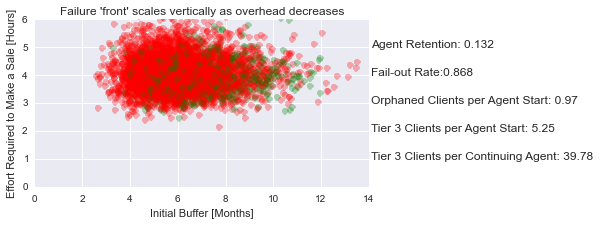

In [73]:
plotter(results1, "Failure 'front' scales vertically as overhead decreases")

## Startup Subsidy

In [74]:
params={'startup_subsidy':.3,'startup_subsidy_length':6}
results2 = [runner(case, params) for case in cases[:]]

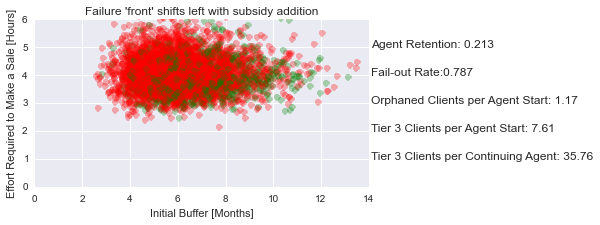

In [75]:
plotter(results2, "Failure 'front' shifts left with subsidy addition")

## Performance Monitoring

In [76]:
params={'startup_subsidy':.3,'startup_subsidy_length':6}

#results3 = [runner(case, params) for case in cases[:]]
results3 = []# [runner(case, params) for case in cases[:]]
for case in cases[:]:
    case['fraction_of_effort_for_sales'] *= 1.3
    results3.append(runner(case, params))

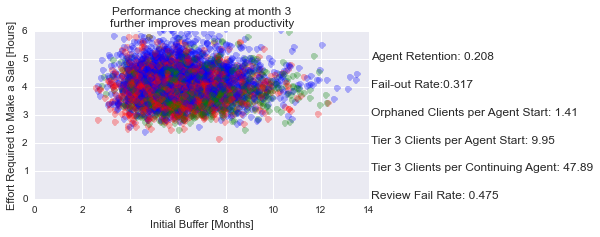

In [77]:
plotter(results3, "Performance checking at month 3\nfurther improves mean productivity", fire_level=4)